# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

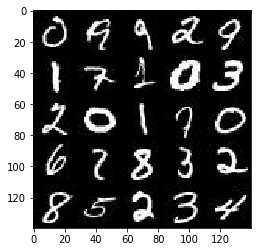

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

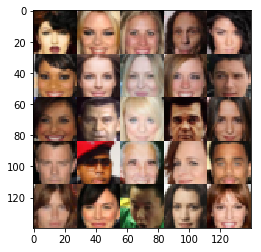

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    Input = tf.placeholder(tf.float32,[None,image_width,image_height,image_channels],name = 'input')
    z = tf.placeholder(tf.float32,[None,z_dim],name = 'Targets')
    LearingRate = tf.placeholder(tf.float32,None,name = 'LearingRate')

    return Input, z, LearingRate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
        
    # TODO: Implement Function
    with tf.variable_scope("discriminator",reuse=reuse):
        alpha = 0.05
        dropout_rate = 0.5

        shape = images.get_shape().as_list()
        channels = shape[3]
  
        x1 = tf.layers.conv2d(images,64,channels,strides=2,
                              kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        x1 = tf.layers.batch_normalization(x1, training=True)
        relu1 = tf.maximum(alpha * x1, x1) #leaky relu
        drop1 = tf.layers.dropout(relu1,dropout_rate)

        x2 = tf.layers.conv2d(drop1,128,5,strides=2,padding='same')
        bn2 = tf.layers.batch_normalization(x2,training=True)
        relu2 = tf.maximum(alpha* bn2, bn2)
        drop2 = tf.layers.dropout(relu2,dropout_rate)


        x3 = tf.layers.conv2d(drop2,256,5,strides=2,padding='same')
        bn3 = tf.layers.batch_normalization(x3,training=True)
        relu3 = tf.maximum(alpha* bn3, bn3)
        drop3 = tf.layers.dropout(relu3,dropout_rate)
        
        # Flatten it
        flat=tf.contrib.layers.flatten(drop3)
        logits = tf.layers.dense(flat,1)
        output=tf.sigmoid(logits)

        return logits, output

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    reuse = not is_train
    alpha = 0.05
    dropout_rate = 0.5
    
    with tf.variable_scope("generator",reuse=reuse):

        x1 = tf.layers.dense(z,7*7*512)
        x1 = tf.reshape(x1,shape=(-1,7,7,512))
        x1 = tf.layers.batch_normalization(x1,training=is_train) 
        x1 = tf.maximum(alpha * x1, x1) #leaky relu
        x1 = tf.layers.dropout(x1,dropout_rate)

        x2 = tf.layers.conv2d_transpose(x1,256,5,strides=2,padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.layers.dropout(x2,dropout_rate)

        x3 = tf.layers.conv2d_transpose(x2,128,5,strides=2,padding='same')
        x3 = tf.layers.batch_normalization( x3,training=is_train)
        x3 = tf.maximum(alpha* x3, x3)
        x3 = tf.layers.dropout(x3,dropout_rate)

        #output layer
        logits = tf.layers.conv2d_transpose(x3,out_channel_dim,5,strides=1,padding='same')
        
        output = tf.tanh(logits)

        return output



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function

    g_model = generator(input_z, out_channel_dim, is_train=True)
    
    d_logits_real, d_output_real = discriminator(input_real, reuse=False)
    d_logits_fake, d_output_fake = discriminator(g_model, reuse=True) 
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)*0.9))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.zeros_like(d_logits_fake)*0.9))
    
    d_loss = d_loss_real + d_loss_fake
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.ones_like(d_logits_fake)*0.9))

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

   # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, 
                                             beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, 
                                             beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, 
          data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    losses = []
    steps = 0
    
    print_every=10
    show_every=100
    
    image_width, image_height, image_channels = data_shape[1], data_shape[2], data_shape[3]
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z,image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
              # TODO: Train Model
                steps += 1
                batch_images = 2* batch_images

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z,
                                               lr: learning_rate})
                
                # Call generators multiple times
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, 
                                               lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, 
                                               lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, 
                                               lr: learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)  
                              
    return losses                    

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.7432... Generator Loss: 1.4945
Epoch 1/2... Discriminator Loss: 2.0299... Generator Loss: 0.8603
Epoch 1/2... Discriminator Loss: 1.7538... Generator Loss: 0.9250
Epoch 1/2... Discriminator Loss: 1.6290... Generator Loss: 0.7728
Epoch 1/2... Discriminator Loss: 1.7890... Generator Loss: 0.7480
Epoch 1/2... Discriminator Loss: 1.6740... Generator Loss: 0.9423
Epoch 1/2... Discriminator Loss: 1.6095... Generator Loss: 0.6763
Epoch 1/2... Discriminator Loss: 1.7679... Generator Loss: 1.2075
Epoch 1/2... Discriminator Loss: 1.7333... Generator Loss: 0.9372
Epoch 1/2... Discriminator Loss: 1.6414... Generator Loss: 0.9756


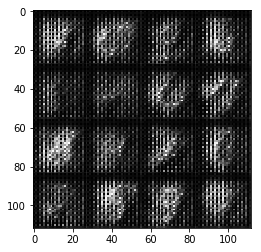

Epoch 1/2... Discriminator Loss: 1.6838... Generator Loss: 0.9758
Epoch 1/2... Discriminator Loss: 1.6921... Generator Loss: 0.6963
Epoch 1/2... Discriminator Loss: 1.6123... Generator Loss: 0.8374
Epoch 1/2... Discriminator Loss: 1.6633... Generator Loss: 0.8813
Epoch 1/2... Discriminator Loss: 1.6413... Generator Loss: 0.7496
Epoch 1/2... Discriminator Loss: 1.6633... Generator Loss: 0.8680
Epoch 1/2... Discriminator Loss: 1.6245... Generator Loss: 0.7433
Epoch 1/2... Discriminator Loss: 1.6243... Generator Loss: 0.8417
Epoch 1/2... Discriminator Loss: 1.5835... Generator Loss: 0.7837
Epoch 1/2... Discriminator Loss: 1.4912... Generator Loss: 0.8296


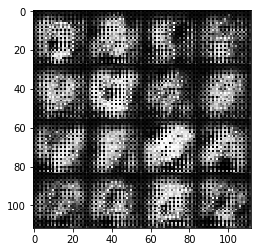

Epoch 1/2... Discriminator Loss: 1.6902... Generator Loss: 0.8043
Epoch 1/2... Discriminator Loss: 1.5917... Generator Loss: 0.8855
Epoch 1/2... Discriminator Loss: 1.6063... Generator Loss: 0.8312
Epoch 1/2... Discriminator Loss: 1.5647... Generator Loss: 0.7822
Epoch 1/2... Discriminator Loss: 1.5780... Generator Loss: 0.8432
Epoch 1/2... Discriminator Loss: 1.5440... Generator Loss: 0.8867
Epoch 1/2... Discriminator Loss: 1.5382... Generator Loss: 0.8708
Epoch 1/2... Discriminator Loss: 1.4979... Generator Loss: 0.7354
Epoch 1/2... Discriminator Loss: 1.6598... Generator Loss: 0.9205
Epoch 1/2... Discriminator Loss: 1.5039... Generator Loss: 0.8011


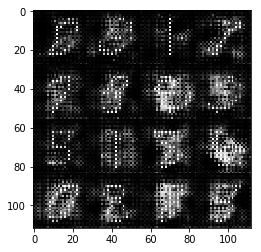

Epoch 1/2... Discriminator Loss: 1.4816... Generator Loss: 0.8049
Epoch 1/2... Discriminator Loss: 1.6068... Generator Loss: 0.8630
Epoch 1/2... Discriminator Loss: 1.6101... Generator Loss: 0.7624
Epoch 1/2... Discriminator Loss: 1.6221... Generator Loss: 0.8077
Epoch 1/2... Discriminator Loss: 1.5746... Generator Loss: 0.9051
Epoch 1/2... Discriminator Loss: 1.6573... Generator Loss: 0.9538
Epoch 1/2... Discriminator Loss: 1.6532... Generator Loss: 0.8528
Epoch 1/2... Discriminator Loss: 1.6072... Generator Loss: 0.7447
Epoch 1/2... Discriminator Loss: 1.5412... Generator Loss: 0.7788
Epoch 1/2... Discriminator Loss: 1.6096... Generator Loss: 0.9123


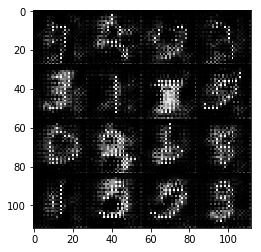

Epoch 1/2... Discriminator Loss: 1.5736... Generator Loss: 0.7372
Epoch 1/2... Discriminator Loss: 1.6698... Generator Loss: 0.9248
Epoch 1/2... Discriminator Loss: 1.8070... Generator Loss: 1.1773
Epoch 1/2... Discriminator Loss: 1.4761... Generator Loss: 0.7733
Epoch 1/2... Discriminator Loss: 1.6333... Generator Loss: 0.5000
Epoch 1/2... Discriminator Loss: 1.6430... Generator Loss: 0.4830
Epoch 2/2... Discriminator Loss: 1.5030... Generator Loss: 0.5817
Epoch 2/2... Discriminator Loss: 1.5758... Generator Loss: 0.9978
Epoch 2/2... Discriminator Loss: 1.5520... Generator Loss: 0.8208
Epoch 2/2... Discriminator Loss: 1.7028... Generator Loss: 0.4538


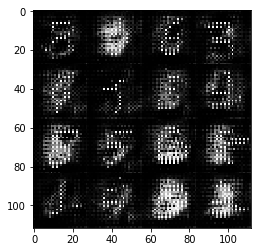

Epoch 2/2... Discriminator Loss: 1.5920... Generator Loss: 0.5127
Epoch 2/2... Discriminator Loss: 1.6833... Generator Loss: 0.4649
Epoch 2/2... Discriminator Loss: 1.7263... Generator Loss: 0.4338
Epoch 2/2... Discriminator Loss: 1.7569... Generator Loss: 0.4222
Epoch 2/2... Discriminator Loss: 1.5757... Generator Loss: 0.5255
Epoch 2/2... Discriminator Loss: 1.8501... Generator Loss: 0.4064
Epoch 2/2... Discriminator Loss: 1.4380... Generator Loss: 0.6954
Epoch 2/2... Discriminator Loss: 1.7857... Generator Loss: 0.4197
Epoch 2/2... Discriminator Loss: 1.8886... Generator Loss: 0.3915
Epoch 2/2... Discriminator Loss: 1.5965... Generator Loss: 0.5260


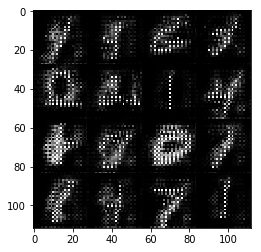

Epoch 2/2... Discriminator Loss: 1.8121... Generator Loss: 0.4145
Epoch 2/2... Discriminator Loss: 1.8944... Generator Loss: 0.3957
Epoch 2/2... Discriminator Loss: 1.6691... Generator Loss: 0.4834
Epoch 2/2... Discriminator Loss: 1.6600... Generator Loss: 0.4884
Epoch 2/2... Discriminator Loss: 1.6991... Generator Loss: 0.4486
Epoch 2/2... Discriminator Loss: 1.5993... Generator Loss: 0.4975
Epoch 2/2... Discriminator Loss: 1.6486... Generator Loss: 0.5172
Epoch 2/2... Discriminator Loss: 1.8142... Generator Loss: 0.4131
Epoch 2/2... Discriminator Loss: 1.6694... Generator Loss: 0.4622
Epoch 2/2... Discriminator Loss: 1.6864... Generator Loss: 0.4384


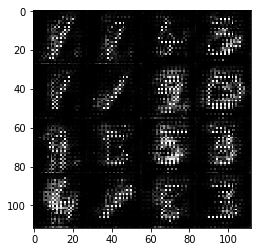

Epoch 2/2... Discriminator Loss: 1.5843... Generator Loss: 0.5602
Epoch 2/2... Discriminator Loss: 1.7763... Generator Loss: 0.4345
Epoch 2/2... Discriminator Loss: 1.6162... Generator Loss: 0.4821
Epoch 2/2... Discriminator Loss: 1.6396... Generator Loss: 0.4790
Epoch 2/2... Discriminator Loss: 1.6835... Generator Loss: 0.4698
Epoch 2/2... Discriminator Loss: 1.7095... Generator Loss: 0.4483
Epoch 2/2... Discriminator Loss: 1.7019... Generator Loss: 0.4396
Epoch 2/2... Discriminator Loss: 1.5726... Generator Loss: 0.6230
Epoch 2/2... Discriminator Loss: 1.4279... Generator Loss: 0.8748
Epoch 2/2... Discriminator Loss: 1.5186... Generator Loss: 0.9015


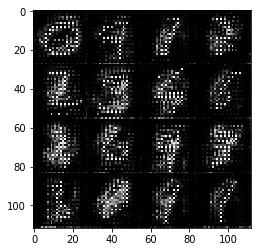

Epoch 2/2... Discriminator Loss: 1.5615... Generator Loss: 0.7090
Epoch 2/2... Discriminator Loss: 1.5901... Generator Loss: 0.5929
Epoch 2/2... Discriminator Loss: 1.8942... Generator Loss: 0.3954
Epoch 2/2... Discriminator Loss: 1.6360... Generator Loss: 0.4941
Epoch 2/2... Discriminator Loss: 1.6546... Generator Loss: 0.4759
Epoch 2/2... Discriminator Loss: 1.5840... Generator Loss: 0.5276
Epoch 2/2... Discriminator Loss: 1.7361... Generator Loss: 0.4454
Epoch 2/2... Discriminator Loss: 1.6463... Generator Loss: 0.4970
Epoch 2/2... Discriminator Loss: 1.5565... Generator Loss: 0.5628
Epoch 2/2... Discriminator Loss: 1.6301... Generator Loss: 0.5007


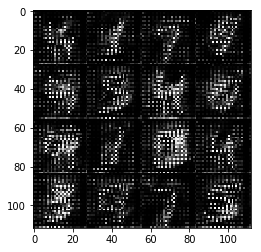

Epoch 2/2... Discriminator Loss: 1.6726... Generator Loss: 0.4660
Epoch 2/2... Discriminator Loss: 1.6838... Generator Loss: 0.4672
Epoch 2/2... Discriminator Loss: 1.6893... Generator Loss: 0.4669


In [14]:
batch_size = 128
z_dim = 200
learning_rate = 0.001
beta1 = 0.3

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 3.3675... Generator Loss: 0.3725
Epoch 1/1... Discriminator Loss: 6.1241... Generator Loss: 5.0526
Epoch 1/1... Discriminator Loss: 1.8831... Generator Loss: 0.4208
Epoch 1/1... Discriminator Loss: 1.2392... Generator Loss: 0.7106
Epoch 1/1... Discriminator Loss: 2.8289... Generator Loss: 0.3275
Epoch 1/1... Discriminator Loss: 2.5690... Generator Loss: 0.3594
Epoch 1/1... Discriminator Loss: 2.1521... Generator Loss: 0.5795
Epoch 1/1... Discriminator Loss: 2.4568... Generator Loss: 0.3753
Epoch 1/1... Discriminator Loss: 2.1188... Generator Loss: 0.4416
Epoch 1/1... Discriminator Loss: 2.1617... Generator Loss: 0.4315


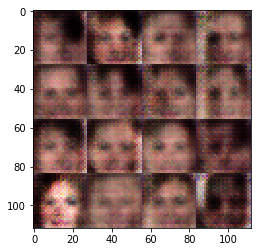

Epoch 1/1... Discriminator Loss: 1.7537... Generator Loss: 0.5114
Epoch 1/1... Discriminator Loss: 1.8527... Generator Loss: 0.4793
Epoch 1/1... Discriminator Loss: 1.8884... Generator Loss: 0.5333
Epoch 1/1... Discriminator Loss: 1.7599... Generator Loss: 0.5586
Epoch 1/1... Discriminator Loss: 1.8756... Generator Loss: 0.5186
Epoch 1/1... Discriminator Loss: 1.8829... Generator Loss: 0.4455
Epoch 1/1... Discriminator Loss: 1.9350... Generator Loss: 0.4248
Epoch 1/1... Discriminator Loss: 1.6998... Generator Loss: 0.6109
Epoch 1/1... Discriminator Loss: 1.6451... Generator Loss: 0.6002
Epoch 1/1... Discriminator Loss: 1.6974... Generator Loss: 0.5293


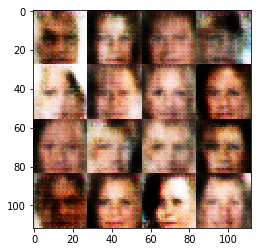

Epoch 1/1... Discriminator Loss: 1.6662... Generator Loss: 0.7121
Epoch 1/1... Discriminator Loss: 1.8634... Generator Loss: 0.4515
Epoch 1/1... Discriminator Loss: 1.6945... Generator Loss: 0.6864
Epoch 1/1... Discriminator Loss: 1.8212... Generator Loss: 0.4606
Epoch 1/1... Discriminator Loss: 1.7449... Generator Loss: 0.5487
Epoch 1/1... Discriminator Loss: 1.6018... Generator Loss: 0.6207
Epoch 1/1... Discriminator Loss: 1.6389... Generator Loss: 0.6711
Epoch 1/1... Discriminator Loss: 1.7027... Generator Loss: 0.4856
Epoch 1/1... Discriminator Loss: 1.7372... Generator Loss: 0.5166
Epoch 1/1... Discriminator Loss: 1.5721... Generator Loss: 0.6536


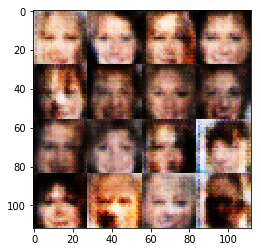

Epoch 1/1... Discriminator Loss: 1.6917... Generator Loss: 0.5645
Epoch 1/1... Discriminator Loss: 1.6406... Generator Loss: 0.5338
Epoch 1/1... Discriminator Loss: 1.6195... Generator Loss: 0.5549
Epoch 1/1... Discriminator Loss: 1.6482... Generator Loss: 0.5439
Epoch 1/1... Discriminator Loss: 1.5991... Generator Loss: 0.5459
Epoch 1/1... Discriminator Loss: 1.6216... Generator Loss: 0.8115
Epoch 1/1... Discriminator Loss: 1.6521... Generator Loss: 0.8415
Epoch 1/1... Discriminator Loss: 1.5548... Generator Loss: 0.6652
Epoch 1/1... Discriminator Loss: 1.6311... Generator Loss: 0.5550
Epoch 1/1... Discriminator Loss: 1.6186... Generator Loss: 0.5550


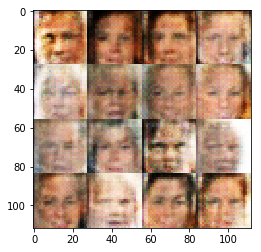

Epoch 1/1... Discriminator Loss: 1.6243... Generator Loss: 0.5405
Epoch 1/1... Discriminator Loss: 1.5881... Generator Loss: 0.6149
Epoch 1/1... Discriminator Loss: 1.6167... Generator Loss: 0.5553
Epoch 1/1... Discriminator Loss: 1.6299... Generator Loss: 0.5059
Epoch 1/1... Discriminator Loss: 1.6837... Generator Loss: 0.5007
Epoch 1/1... Discriminator Loss: 1.6560... Generator Loss: 0.4916
Epoch 1/1... Discriminator Loss: 1.6345... Generator Loss: 0.5284
Epoch 1/1... Discriminator Loss: 1.6059... Generator Loss: 0.5627
Epoch 1/1... Discriminator Loss: 1.6388... Generator Loss: 0.5427
Epoch 1/1... Discriminator Loss: 1.5731... Generator Loss: 0.7647


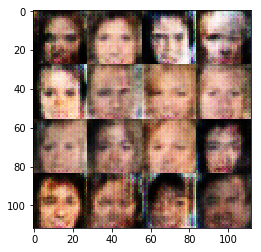

Epoch 1/1... Discriminator Loss: 1.5874... Generator Loss: 0.6275
Epoch 1/1... Discriminator Loss: 1.7567... Generator Loss: 0.4447
Epoch 1/1... Discriminator Loss: 1.7096... Generator Loss: 0.5396
Epoch 1/1... Discriminator Loss: 1.5549... Generator Loss: 0.6138
Epoch 1/1... Discriminator Loss: 1.6438... Generator Loss: 0.4837
Epoch 1/1... Discriminator Loss: 1.6584... Generator Loss: 0.4694
Epoch 1/1... Discriminator Loss: 1.5679... Generator Loss: 0.5557
Epoch 1/1... Discriminator Loss: 1.5984... Generator Loss: 0.5089
Epoch 1/1... Discriminator Loss: 1.6179... Generator Loss: 0.6663
Epoch 1/1... Discriminator Loss: 1.5132... Generator Loss: 0.7438


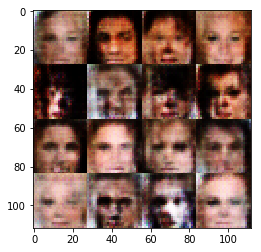

Epoch 1/1... Discriminator Loss: 1.5779... Generator Loss: 0.6445
Epoch 1/1... Discriminator Loss: 1.5851... Generator Loss: 0.5968
Epoch 1/1... Discriminator Loss: 1.5727... Generator Loss: 0.8798
Epoch 1/1... Discriminator Loss: 1.6022... Generator Loss: 0.8203
Epoch 1/1... Discriminator Loss: 1.5792... Generator Loss: 0.7041
Epoch 1/1... Discriminator Loss: 1.5799... Generator Loss: 0.6806
Epoch 1/1... Discriminator Loss: 1.5642... Generator Loss: 0.6076
Epoch 1/1... Discriminator Loss: 1.5288... Generator Loss: 0.6241
Epoch 1/1... Discriminator Loss: 1.5723... Generator Loss: 0.5894
Epoch 1/1... Discriminator Loss: 1.5906... Generator Loss: 0.5617


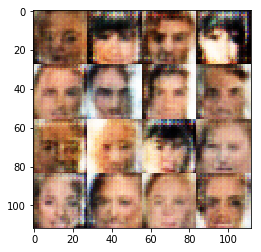

Epoch 1/1... Discriminator Loss: 1.5691... Generator Loss: 0.5793
Epoch 1/1... Discriminator Loss: 1.6520... Generator Loss: 0.5719
Epoch 1/1... Discriminator Loss: 1.5815... Generator Loss: 0.7073
Epoch 1/1... Discriminator Loss: 1.5547... Generator Loss: 0.6890
Epoch 1/1... Discriminator Loss: 1.6152... Generator Loss: 0.5932
Epoch 1/1... Discriminator Loss: 1.5696... Generator Loss: 0.8612
Epoch 1/1... Discriminator Loss: 1.6788... Generator Loss: 0.5075
Epoch 1/1... Discriminator Loss: 1.5314... Generator Loss: 0.6333
Epoch 1/1... Discriminator Loss: 1.7170... Generator Loss: 0.5668
Epoch 1/1... Discriminator Loss: 1.5794... Generator Loss: 0.8123


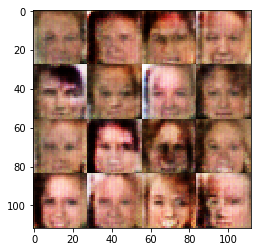

Epoch 1/1... Discriminator Loss: 1.5404... Generator Loss: 0.6858
Epoch 1/1... Discriminator Loss: 1.5621... Generator Loss: 0.6894
Epoch 1/1... Discriminator Loss: 1.5315... Generator Loss: 0.6295
Epoch 1/1... Discriminator Loss: 1.5372... Generator Loss: 0.6406
Epoch 1/1... Discriminator Loss: 1.5895... Generator Loss: 0.5339
Epoch 1/1... Discriminator Loss: 1.6092... Generator Loss: 0.5335
Epoch 1/1... Discriminator Loss: 1.5471... Generator Loss: 0.5838
Epoch 1/1... Discriminator Loss: 1.5715... Generator Loss: 0.5396
Epoch 1/1... Discriminator Loss: 1.6274... Generator Loss: 0.6356
Epoch 1/1... Discriminator Loss: 1.5528... Generator Loss: 0.5838


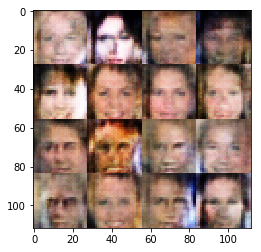

Epoch 1/1... Discriminator Loss: 1.5662... Generator Loss: 0.7021
Epoch 1/1... Discriminator Loss: 1.5221... Generator Loss: 0.6948
Epoch 1/1... Discriminator Loss: 1.5913... Generator Loss: 0.5370
Epoch 1/1... Discriminator Loss: 1.5457... Generator Loss: 0.5875
Epoch 1/1... Discriminator Loss: 1.4818... Generator Loss: 0.7222
Epoch 1/1... Discriminator Loss: 1.6410... Generator Loss: 0.5235
Epoch 1/1... Discriminator Loss: 1.5809... Generator Loss: 0.5984
Epoch 1/1... Discriminator Loss: 1.5569... Generator Loss: 0.6121
Epoch 1/1... Discriminator Loss: 1.6620... Generator Loss: 0.5309
Epoch 1/1... Discriminator Loss: 1.5066... Generator Loss: 0.6628


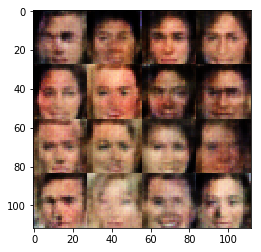

Epoch 1/1... Discriminator Loss: 1.5529... Generator Loss: 0.7490
Epoch 1/1... Discriminator Loss: 1.6043... Generator Loss: 0.5576
Epoch 1/1... Discriminator Loss: 1.5158... Generator Loss: 0.7538
Epoch 1/1... Discriminator Loss: 1.5842... Generator Loss: 0.7231
Epoch 1/1... Discriminator Loss: 1.5731... Generator Loss: 0.5959
Epoch 1/1... Discriminator Loss: 1.6423... Generator Loss: 0.5692
Epoch 1/1... Discriminator Loss: 1.5547... Generator Loss: 0.5808
Epoch 1/1... Discriminator Loss: 1.5117... Generator Loss: 0.6029
Epoch 1/1... Discriminator Loss: 1.5222... Generator Loss: 0.6661
Epoch 1/1... Discriminator Loss: 1.5328... Generator Loss: 0.7805


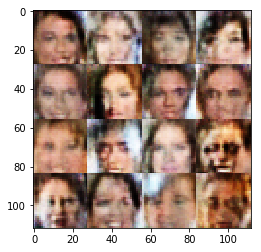

Epoch 1/1... Discriminator Loss: 1.5779... Generator Loss: 0.5542
Epoch 1/1... Discriminator Loss: 1.5781... Generator Loss: 0.5628
Epoch 1/1... Discriminator Loss: 1.5983... Generator Loss: 0.6572
Epoch 1/1... Discriminator Loss: 1.5238... Generator Loss: 0.6859
Epoch 1/1... Discriminator Loss: 1.5706... Generator Loss: 0.5791
Epoch 1/1... Discriminator Loss: 1.5614... Generator Loss: 0.5900
Epoch 1/1... Discriminator Loss: 1.4895... Generator Loss: 0.7378
Epoch 1/1... Discriminator Loss: 1.5211... Generator Loss: 0.5932
Epoch 1/1... Discriminator Loss: 1.5525... Generator Loss: 0.5829
Epoch 1/1... Discriminator Loss: 1.6151... Generator Loss: 0.6209


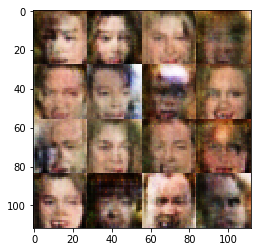

Epoch 1/1... Discriminator Loss: 1.4854... Generator Loss: 0.6885
Epoch 1/1... Discriminator Loss: 1.4783... Generator Loss: 0.7159
Epoch 1/1... Discriminator Loss: 1.5420... Generator Loss: 0.8111
Epoch 1/1... Discriminator Loss: 1.5025... Generator Loss: 0.7069
Epoch 1/1... Discriminator Loss: 1.5245... Generator Loss: 0.6769
Epoch 1/1... Discriminator Loss: 1.5271... Generator Loss: 0.6053
Epoch 1/1... Discriminator Loss: 1.4866... Generator Loss: 0.7962
Epoch 1/1... Discriminator Loss: 1.5875... Generator Loss: 1.0057
Epoch 1/1... Discriminator Loss: 1.4877... Generator Loss: 0.6566
Epoch 1/1... Discriminator Loss: 1.4957... Generator Loss: 0.6674


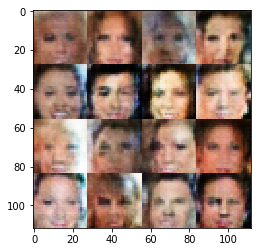

Epoch 1/1... Discriminator Loss: 1.5489... Generator Loss: 0.6825
Epoch 1/1... Discriminator Loss: 1.6094... Generator Loss: 0.5004
Epoch 1/1... Discriminator Loss: 1.5703... Generator Loss: 0.5846
Epoch 1/1... Discriminator Loss: 1.5077... Generator Loss: 0.6062
Epoch 1/1... Discriminator Loss: 1.4878... Generator Loss: 0.7307
Epoch 1/1... Discriminator Loss: 1.5614... Generator Loss: 0.6581
Epoch 1/1... Discriminator Loss: 1.4972... Generator Loss: 0.6858
Epoch 1/1... Discriminator Loss: 1.5620... Generator Loss: 0.5238
Epoch 1/1... Discriminator Loss: 1.5454... Generator Loss: 0.6543
Epoch 1/1... Discriminator Loss: 1.5023... Generator Loss: 0.7944


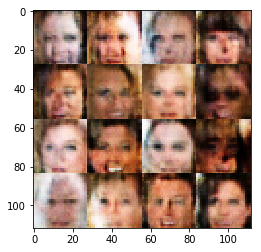

Epoch 1/1... Discriminator Loss: 1.4978... Generator Loss: 0.8017
Epoch 1/1... Discriminator Loss: 1.4960... Generator Loss: 0.6746
Epoch 1/1... Discriminator Loss: 1.5763... Generator Loss: 0.5941
Epoch 1/1... Discriminator Loss: 1.5223... Generator Loss: 0.6003
Epoch 1/1... Discriminator Loss: 1.4904... Generator Loss: 0.6585
Epoch 1/1... Discriminator Loss: 1.5833... Generator Loss: 0.5921
Epoch 1/1... Discriminator Loss: 1.5148... Generator Loss: 0.5973
Epoch 1/1... Discriminator Loss: 1.5176... Generator Loss: 0.6511
Epoch 1/1... Discriminator Loss: 1.5354... Generator Loss: 0.7310
Epoch 1/1... Discriminator Loss: 1.5131... Generator Loss: 0.6097


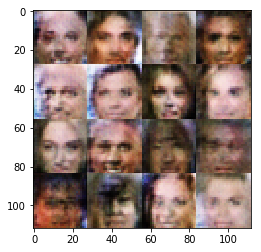

Epoch 1/1... Discriminator Loss: 1.6002... Generator Loss: 0.5119
Epoch 1/1... Discriminator Loss: 1.5426... Generator Loss: 0.6117
Epoch 1/1... Discriminator Loss: 1.5178... Generator Loss: 0.6645
Epoch 1/1... Discriminator Loss: 1.5368... Generator Loss: 0.5999
Epoch 1/1... Discriminator Loss: 1.4899... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.5200... Generator Loss: 0.7273
Epoch 1/1... Discriminator Loss: 1.5613... Generator Loss: 0.5906
Epoch 1/1... Discriminator Loss: 1.4946... Generator Loss: 0.6329
Epoch 1/1... Discriminator Loss: 1.5159... Generator Loss: 0.8094
Epoch 1/1... Discriminator Loss: 1.4885... Generator Loss: 0.7196


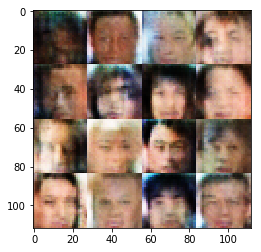

Epoch 1/1... Discriminator Loss: 1.5253... Generator Loss: 0.8111
Epoch 1/1... Discriminator Loss: 1.4619... Generator Loss: 0.6457
Epoch 1/1... Discriminator Loss: 1.4852... Generator Loss: 0.7188
Epoch 1/1... Discriminator Loss: 1.5010... Generator Loss: 0.6146
Epoch 1/1... Discriminator Loss: 1.5058... Generator Loss: 0.6431
Epoch 1/1... Discriminator Loss: 1.4907... Generator Loss: 0.6937
Epoch 1/1... Discriminator Loss: 1.6246... Generator Loss: 0.5472
Epoch 1/1... Discriminator Loss: 1.5345... Generator Loss: 0.8851
Epoch 1/1... Discriminator Loss: 1.5446... Generator Loss: 0.6752
Epoch 1/1... Discriminator Loss: 1.5660... Generator Loss: 0.5431


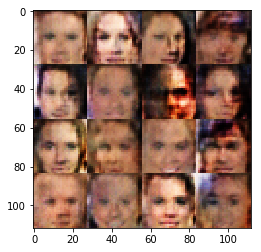

Epoch 1/1... Discriminator Loss: 1.5360... Generator Loss: 0.5631
Epoch 1/1... Discriminator Loss: 1.4762... Generator Loss: 0.6277
Epoch 1/1... Discriminator Loss: 1.4703... Generator Loss: 0.7368
Epoch 1/1... Discriminator Loss: 1.4942... Generator Loss: 0.7211
Epoch 1/1... Discriminator Loss: 1.5372... Generator Loss: 0.5860
Epoch 1/1... Discriminator Loss: 1.4608... Generator Loss: 0.7310
Epoch 1/1... Discriminator Loss: 1.5005... Generator Loss: 0.7108
Epoch 1/1... Discriminator Loss: 1.4753... Generator Loss: 0.6470
Epoch 1/1... Discriminator Loss: 1.5631... Generator Loss: 0.8772
Epoch 1/1... Discriminator Loss: 1.5356... Generator Loss: 0.7120


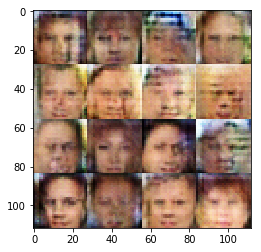

Epoch 1/1... Discriminator Loss: 1.4806... Generator Loss: 0.6898
Epoch 1/1... Discriminator Loss: 1.6073... Generator Loss: 0.5776
Epoch 1/1... Discriminator Loss: 1.5299... Generator Loss: 0.7074
Epoch 1/1... Discriminator Loss: 1.4707... Generator Loss: 0.6605
Epoch 1/1... Discriminator Loss: 1.4503... Generator Loss: 0.7873
Epoch 1/1... Discriminator Loss: 1.5840... Generator Loss: 0.5380
Epoch 1/1... Discriminator Loss: 1.5215... Generator Loss: 0.5754
Epoch 1/1... Discriminator Loss: 1.4933... Generator Loss: 0.6277
Epoch 1/1... Discriminator Loss: 1.4610... Generator Loss: 0.7151
Epoch 1/1... Discriminator Loss: 1.4592... Generator Loss: 0.7785


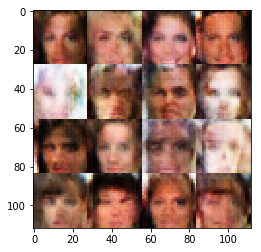

Epoch 1/1... Discriminator Loss: 1.5100... Generator Loss: 0.8002
Epoch 1/1... Discriminator Loss: 1.4499... Generator Loss: 0.6421
Epoch 1/1... Discriminator Loss: 1.5143... Generator Loss: 0.6441
Epoch 1/1... Discriminator Loss: 1.4662... Generator Loss: 0.7606
Epoch 1/1... Discriminator Loss: 1.4653... Generator Loss: 0.6672
Epoch 1/1... Discriminator Loss: 1.4332... Generator Loss: 0.6882
Epoch 1/1... Discriminator Loss: 1.4634... Generator Loss: 0.7913
Epoch 1/1... Discriminator Loss: 1.4788... Generator Loss: 0.6750
Epoch 1/1... Discriminator Loss: 1.5050... Generator Loss: 0.6344
Epoch 1/1... Discriminator Loss: 1.4796... Generator Loss: 0.6324


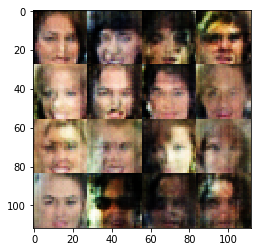

Epoch 1/1... Discriminator Loss: 1.4555... Generator Loss: 0.7669
Epoch 1/1... Discriminator Loss: 1.5140... Generator Loss: 0.9238
Epoch 1/1... Discriminator Loss: 1.4848... Generator Loss: 0.6893
Epoch 1/1... Discriminator Loss: 1.4814... Generator Loss: 0.6092
Epoch 1/1... Discriminator Loss: 1.5080... Generator Loss: 0.7806
Epoch 1/1... Discriminator Loss: 1.5781... Generator Loss: 0.5388
Epoch 1/1... Discriminator Loss: 1.5293... Generator Loss: 0.8551
Epoch 1/1... Discriminator Loss: 1.4674... Generator Loss: 0.7037
Epoch 1/1... Discriminator Loss: 1.4989... Generator Loss: 0.5932
Epoch 1/1... Discriminator Loss: 1.4822... Generator Loss: 0.7460


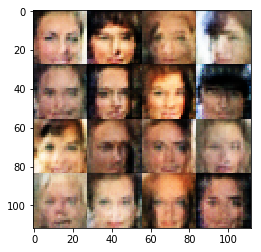

Epoch 1/1... Discriminator Loss: 1.4721... Generator Loss: 0.6635
Epoch 1/1... Discriminator Loss: 1.4488... Generator Loss: 0.7282
Epoch 1/1... Discriminator Loss: 1.4851... Generator Loss: 0.7347
Epoch 1/1... Discriminator Loss: 1.4947... Generator Loss: 0.8913
Epoch 1/1... Discriminator Loss: 1.5003... Generator Loss: 0.6719
Epoch 1/1... Discriminator Loss: 1.5172... Generator Loss: 0.7275
Epoch 1/1... Discriminator Loss: 1.4905... Generator Loss: 0.6530
Epoch 1/1... Discriminator Loss: 1.4639... Generator Loss: 0.7140
Epoch 1/1... Discriminator Loss: 1.4952... Generator Loss: 0.6695
Epoch 1/1... Discriminator Loss: 1.4798... Generator Loss: 0.5912


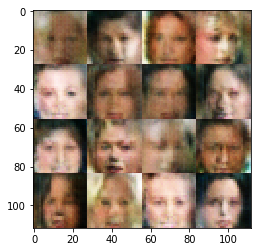

Epoch 1/1... Discriminator Loss: 1.4595... Generator Loss: 0.7429
Epoch 1/1... Discriminator Loss: 1.4645... Generator Loss: 0.6527
Epoch 1/1... Discriminator Loss: 1.5543... Generator Loss: 0.6156
Epoch 1/1... Discriminator Loss: 1.4521... Generator Loss: 0.6962
Epoch 1/1... Discriminator Loss: 1.4519... Generator Loss: 0.8488
Epoch 1/1... Discriminator Loss: 1.5275... Generator Loss: 0.6011
Epoch 1/1... Discriminator Loss: 1.4527... Generator Loss: 0.7613
Epoch 1/1... Discriminator Loss: 1.4452... Generator Loss: 0.7588
Epoch 1/1... Discriminator Loss: 1.4789... Generator Loss: 0.6055
Epoch 1/1... Discriminator Loss: 1.4589... Generator Loss: 0.6733


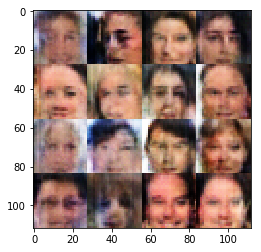

Epoch 1/1... Discriminator Loss: 1.4691... Generator Loss: 0.6953
Epoch 1/1... Discriminator Loss: 1.4910... Generator Loss: 0.6117
Epoch 1/1... Discriminator Loss: 1.4743... Generator Loss: 0.6833
Epoch 1/1... Discriminator Loss: 1.4441... Generator Loss: 0.6864
Epoch 1/1... Discriminator Loss: 1.4902... Generator Loss: 0.8463
Epoch 1/1... Discriminator Loss: 1.4411... Generator Loss: 0.7419
Epoch 1/1... Discriminator Loss: 1.5075... Generator Loss: 0.6319
Epoch 1/1... Discriminator Loss: 1.5011... Generator Loss: 0.8755
Epoch 1/1... Discriminator Loss: 1.4551... Generator Loss: 0.7292
Epoch 1/1... Discriminator Loss: 1.4733... Generator Loss: 0.6111


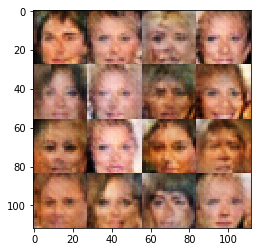

Epoch 1/1... Discriminator Loss: 1.5253... Generator Loss: 0.5576
Epoch 1/1... Discriminator Loss: 1.4702... Generator Loss: 0.8093
Epoch 1/1... Discriminator Loss: 1.4605... Generator Loss: 0.6616
Epoch 1/1... Discriminator Loss: 1.4849... Generator Loss: 0.6033
Epoch 1/1... Discriminator Loss: 1.4355... Generator Loss: 0.7564
Epoch 1/1... Discriminator Loss: 1.4508... Generator Loss: 0.7533
Epoch 1/1... Discriminator Loss: 1.4775... Generator Loss: 0.6305
Epoch 1/1... Discriminator Loss: 1.4666... Generator Loss: 0.6734
Epoch 1/1... Discriminator Loss: 1.4739... Generator Loss: 0.7520
Epoch 1/1... Discriminator Loss: 1.4508... Generator Loss: 0.7010


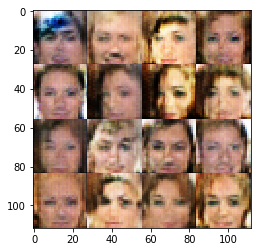

Epoch 1/1... Discriminator Loss: 1.4448... Generator Loss: 0.7459
Epoch 1/1... Discriminator Loss: 1.4652... Generator Loss: 0.6759
Epoch 1/1... Discriminator Loss: 1.4762... Generator Loss: 0.6398
Epoch 1/1... Discriminator Loss: 1.4689... Generator Loss: 0.7270
Epoch 1/1... Discriminator Loss: 1.4455... Generator Loss: 0.7295
Epoch 1/1... Discriminator Loss: 1.4489... Generator Loss: 0.6938
Epoch 1/1... Discriminator Loss: 1.4722... Generator Loss: 0.6084
Epoch 1/1... Discriminator Loss: 1.4549... Generator Loss: 0.6573
Epoch 1/1... Discriminator Loss: 1.4674... Generator Loss: 0.7076
Epoch 1/1... Discriminator Loss: 1.4891... Generator Loss: 0.7740


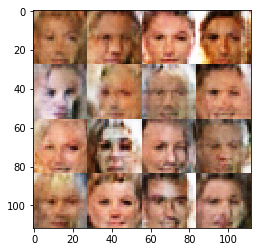

Epoch 1/1... Discriminator Loss: 1.4636... Generator Loss: 0.6856
Epoch 1/1... Discriminator Loss: 1.4628... Generator Loss: 0.6874
Epoch 1/1... Discriminator Loss: 1.4880... Generator Loss: 0.6366
Epoch 1/1... Discriminator Loss: 1.5063... Generator Loss: 0.9409
Epoch 1/1... Discriminator Loss: 1.4375... Generator Loss: 0.7569
Epoch 1/1... Discriminator Loss: 1.5050... Generator Loss: 0.7868
Epoch 1/1... Discriminator Loss: 1.4409... Generator Loss: 0.7550
Epoch 1/1... Discriminator Loss: 1.5338... Generator Loss: 0.5260
Epoch 1/1... Discriminator Loss: 1.4779... Generator Loss: 0.6585
Epoch 1/1... Discriminator Loss: 1.4811... Generator Loss: 0.7007


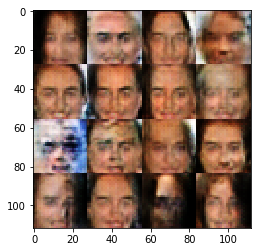

Epoch 1/1... Discriminator Loss: 1.4495... Generator Loss: 0.6670
Epoch 1/1... Discriminator Loss: 1.4805... Generator Loss: 0.7498
Epoch 1/1... Discriminator Loss: 1.4816... Generator Loss: 0.6241
Epoch 1/1... Discriminator Loss: 1.4470... Generator Loss: 0.7062
Epoch 1/1... Discriminator Loss: 1.4376... Generator Loss: 0.7130
Epoch 1/1... Discriminator Loss: 1.5727... Generator Loss: 0.5596
Epoch 1/1... Discriminator Loss: 1.4693... Generator Loss: 0.6546
Epoch 1/1... Discriminator Loss: 1.4411... Generator Loss: 0.7211
Epoch 1/1... Discriminator Loss: 1.4499... Generator Loss: 0.8518
Epoch 1/1... Discriminator Loss: 1.4677... Generator Loss: 0.8331


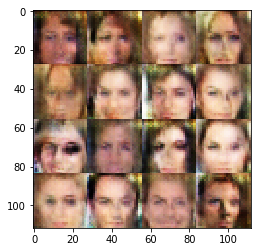

Epoch 1/1... Discriminator Loss: 1.4787... Generator Loss: 0.6149
Epoch 1/1... Discriminator Loss: 1.4554... Generator Loss: 0.6891
Epoch 1/1... Discriminator Loss: 1.4683... Generator Loss: 0.6519
Epoch 1/1... Discriminator Loss: 1.4577... Generator Loss: 0.7809
Epoch 1/1... Discriminator Loss: 1.4638... Generator Loss: 0.6551
Epoch 1/1... Discriminator Loss: 1.5112... Generator Loss: 0.6768
Epoch 1/1... Discriminator Loss: 1.4792... Generator Loss: 0.6141
Epoch 1/1... Discriminator Loss: 1.4496... Generator Loss: 0.7710
Epoch 1/1... Discriminator Loss: 1.4650... Generator Loss: 0.7191
Epoch 1/1... Discriminator Loss: 1.4462... Generator Loss: 0.6665


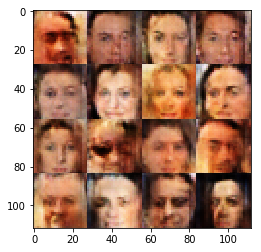

Epoch 1/1... Discriminator Loss: 1.4471... Generator Loss: 0.7199
Epoch 1/1... Discriminator Loss: 1.4492... Generator Loss: 0.6966
Epoch 1/1... Discriminator Loss: 1.4421... Generator Loss: 0.7451
Epoch 1/1... Discriminator Loss: 1.4756... Generator Loss: 0.7004
Epoch 1/1... Discriminator Loss: 1.4717... Generator Loss: 0.6214
Epoch 1/1... Discriminator Loss: 1.4573... Generator Loss: 0.6485
Epoch 1/1... Discriminator Loss: 1.4910... Generator Loss: 0.8079
Epoch 1/1... Discriminator Loss: 1.4309... Generator Loss: 0.8079
Epoch 1/1... Discriminator Loss: 1.4574... Generator Loss: 0.7089
Epoch 1/1... Discriminator Loss: 1.4545... Generator Loss: 0.7337


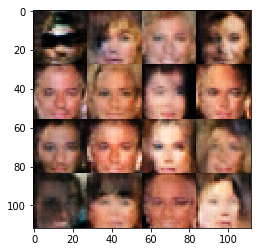

Epoch 1/1... Discriminator Loss: 1.4554... Generator Loss: 0.7133
Epoch 1/1... Discriminator Loss: 1.4560... Generator Loss: 0.6777
Epoch 1/1... Discriminator Loss: 1.4275... Generator Loss: 0.7227
Epoch 1/1... Discriminator Loss: 1.4365... Generator Loss: 0.7920
Epoch 1/1... Discriminator Loss: 1.4600... Generator Loss: 0.6957
Epoch 1/1... Discriminator Loss: 1.4418... Generator Loss: 0.6950
Epoch 1/1... Discriminator Loss: 1.4413... Generator Loss: 0.7552
Epoch 1/1... Discriminator Loss: 1.4525... Generator Loss: 0.7808
Epoch 1/1... Discriminator Loss: 1.4575... Generator Loss: 0.8127
Epoch 1/1... Discriminator Loss: 1.4536... Generator Loss: 0.6578


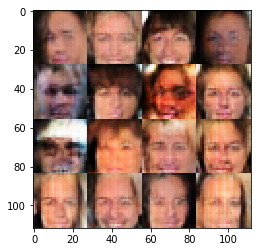

Epoch 1/1... Discriminator Loss: 1.4236... Generator Loss: 0.7327
Epoch 1/1... Discriminator Loss: 1.4542... Generator Loss: 0.6974
Epoch 1/1... Discriminator Loss: 1.4359... Generator Loss: 0.7928
Epoch 1/1... Discriminator Loss: 1.4452... Generator Loss: 0.7228
Epoch 1/1... Discriminator Loss: 1.4384... Generator Loss: 0.8147
Epoch 1/1... Discriminator Loss: 1.4475... Generator Loss: 0.7270
Epoch 1/1... Discriminator Loss: 1.4573... Generator Loss: 0.7152
Epoch 1/1... Discriminator Loss: 1.4599... Generator Loss: 0.6409
Epoch 1/1... Discriminator Loss: 1.4371... Generator Loss: 0.7495
Epoch 1/1... Discriminator Loss: 1.4582... Generator Loss: 0.7298


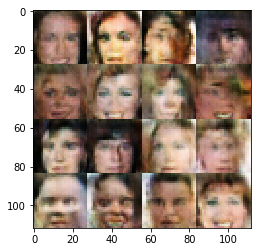

Epoch 1/1... Discriminator Loss: 1.4588... Generator Loss: 0.6980
Epoch 1/1... Discriminator Loss: 1.4949... Generator Loss: 0.5817
Epoch 1/1... Discriminator Loss: 1.4481... Generator Loss: 0.7606
Epoch 1/1... Discriminator Loss: 1.4483... Generator Loss: 0.8431
Epoch 1/1... Discriminator Loss: 1.4362... Generator Loss: 0.6728
Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 0.8108
Epoch 1/1... Discriminator Loss: 1.4552... Generator Loss: 0.6420
Epoch 1/1... Discriminator Loss: 1.4409... Generator Loss: 0.6892
Epoch 1/1... Discriminator Loss: 1.4509... Generator Loss: 0.6601
Epoch 1/1... Discriminator Loss: 1.4479... Generator Loss: 0.6592


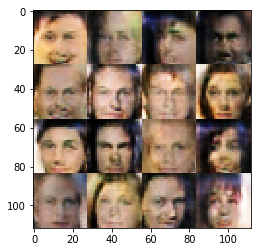

Epoch 1/1... Discriminator Loss: 1.4378... Generator Loss: 0.7687
Epoch 1/1... Discriminator Loss: 1.4234... Generator Loss: 0.6804
Epoch 1/1... Discriminator Loss: 1.4381... Generator Loss: 0.7839
Epoch 1/1... Discriminator Loss: 1.4622... Generator Loss: 0.8693
Epoch 1/1... Discriminator Loss: 1.4435... Generator Loss: 0.6761
Epoch 1/1... Discriminator Loss: 1.4249... Generator Loss: 0.6999
Epoch 1/1... Discriminator Loss: 1.4390... Generator Loss: 0.7332
Epoch 1/1... Discriminator Loss: 1.4563... Generator Loss: 0.6503
Epoch 1/1... Discriminator Loss: 1.4722... Generator Loss: 0.6303
Epoch 1/1... Discriminator Loss: 1.5249... Generator Loss: 0.5605


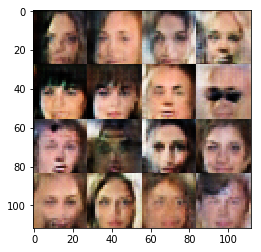

Epoch 1/1... Discriminator Loss: 1.4311... Generator Loss: 0.7345
Epoch 1/1... Discriminator Loss: 1.4369... Generator Loss: 0.7283
Epoch 1/1... Discriminator Loss: 1.4249... Generator Loss: 0.7161
Epoch 1/1... Discriminator Loss: 1.4346... Generator Loss: 0.8127
Epoch 1/1... Discriminator Loss: 1.4246... Generator Loss: 0.7068
Epoch 1/1... Discriminator Loss: 1.4387... Generator Loss: 0.7751
Epoch 1/1... Discriminator Loss: 1.4330... Generator Loss: 0.6810
Epoch 1/1... Discriminator Loss: 1.4167... Generator Loss: 0.7855
Epoch 1/1... Discriminator Loss: 1.4648... Generator Loss: 0.6577
Epoch 1/1... Discriminator Loss: 1.4143... Generator Loss: 0.7640


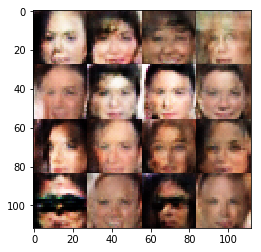

Epoch 1/1... Discriminator Loss: 1.4365... Generator Loss: 0.7056
Epoch 1/1... Discriminator Loss: 1.4331... Generator Loss: 0.7956
Epoch 1/1... Discriminator Loss: 1.4482... Generator Loss: 0.6564
Epoch 1/1... Discriminator Loss: 1.4474... Generator Loss: 0.6411
Epoch 1/1... Discriminator Loss: 1.4165... Generator Loss: 0.6718
Epoch 1/1... Discriminator Loss: 1.4255... Generator Loss: 0.6851
Epoch 1/1... Discriminator Loss: 1.4293... Generator Loss: 0.7014
Epoch 1/1... Discriminator Loss: 1.4318... Generator Loss: 0.7873
Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 0.7160
Epoch 1/1... Discriminator Loss: 1.4296... Generator Loss: 0.7561


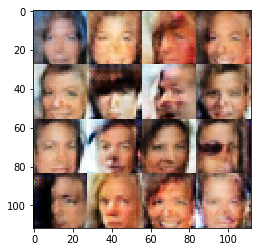

Epoch 1/1... Discriminator Loss: 1.4276... Generator Loss: 0.7086
Epoch 1/1... Discriminator Loss: 1.4476... Generator Loss: 0.6648
Epoch 1/1... Discriminator Loss: 1.4248... Generator Loss: 0.6906
Epoch 1/1... Discriminator Loss: 1.4216... Generator Loss: 0.7392
Epoch 1/1... Discriminator Loss: 1.4265... Generator Loss: 0.7541
Epoch 1/1... Discriminator Loss: 1.4337... Generator Loss: 0.8177
Epoch 1/1... Discriminator Loss: 1.4584... Generator Loss: 0.6061
Epoch 1/1... Discriminator Loss: 1.4248... Generator Loss: 0.6927
Epoch 1/1... Discriminator Loss: 1.4316... Generator Loss: 0.7104
Epoch 1/1... Discriminator Loss: 1.4296... Generator Loss: 0.7256


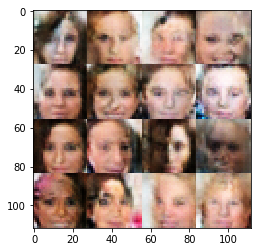

Epoch 1/1... Discriminator Loss: 1.4821... Generator Loss: 0.6141
Epoch 1/1... Discriminator Loss: 1.4369... Generator Loss: 0.8188
Epoch 1/1... Discriminator Loss: 1.4464... Generator Loss: 0.8288
Epoch 1/1... Discriminator Loss: 1.4235... Generator Loss: 0.6876
Epoch 1/1... Discriminator Loss: 1.4348... Generator Loss: 0.6817
Epoch 1/1... Discriminator Loss: 1.4244... Generator Loss: 0.8333
Epoch 1/1... Discriminator Loss: 1.4410... Generator Loss: 0.7355
Epoch 1/1... Discriminator Loss: 1.4352... Generator Loss: 0.7594
Epoch 1/1... Discriminator Loss: 1.4318... Generator Loss: 0.6730
Epoch 1/1... Discriminator Loss: 1.4466... Generator Loss: 0.7263


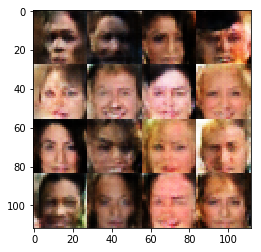

Epoch 1/1... Discriminator Loss: 1.4358... Generator Loss: 0.7079
Epoch 1/1... Discriminator Loss: 1.4352... Generator Loss: 0.7462
Epoch 1/1... Discriminator Loss: 1.4330... Generator Loss: 0.6732
Epoch 1/1... Discriminator Loss: 1.4451... Generator Loss: 0.7859
Epoch 1/1... Discriminator Loss: 1.4682... Generator Loss: 0.6018
Epoch 1/1... Discriminator Loss: 1.4385... Generator Loss: 0.6986
Epoch 1/1... Discriminator Loss: 1.4374... Generator Loss: 0.7349
Epoch 1/1... Discriminator Loss: 1.4445... Generator Loss: 0.7020
Epoch 1/1... Discriminator Loss: 1.4299... Generator Loss: 0.8052
Epoch 1/1... Discriminator Loss: 1.4300... Generator Loss: 0.7407


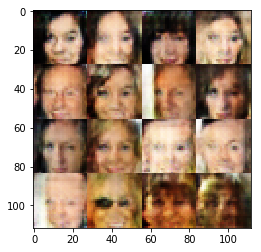

Epoch 1/1... Discriminator Loss: 1.5007... Generator Loss: 0.5537
Epoch 1/1... Discriminator Loss: 1.4365... Generator Loss: 0.7682
Epoch 1/1... Discriminator Loss: 1.4338... Generator Loss: 0.6679
Epoch 1/1... Discriminator Loss: 1.4430... Generator Loss: 0.7485
Epoch 1/1... Discriminator Loss: 1.4244... Generator Loss: 0.7481
Epoch 1/1... Discriminator Loss: 1.4332... Generator Loss: 0.7939
Epoch 1/1... Discriminator Loss: 1.4280... Generator Loss: 0.7969
Epoch 1/1... Discriminator Loss: 1.4300... Generator Loss: 0.6678
Epoch 1/1... Discriminator Loss: 1.4183... Generator Loss: 0.7759
Epoch 1/1... Discriminator Loss: 1.4419... Generator Loss: 0.6863


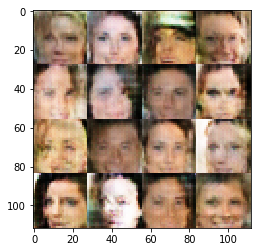

Epoch 1/1... Discriminator Loss: 1.4349... Generator Loss: 0.6782
Epoch 1/1... Discriminator Loss: 1.4335... Generator Loss: 0.7121
Epoch 1/1... Discriminator Loss: 1.4244... Generator Loss: 0.7360
Epoch 1/1... Discriminator Loss: 1.4422... Generator Loss: 0.6826
Epoch 1/1... Discriminator Loss: 1.4309... Generator Loss: 0.7102
Epoch 1/1... Discriminator Loss: 1.4283... Generator Loss: 0.7152
Epoch 1/1... Discriminator Loss: 1.4182... Generator Loss: 0.7560
Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 0.7754
Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 0.7547
Epoch 1/1... Discriminator Loss: 1.4241... Generator Loss: 0.7419


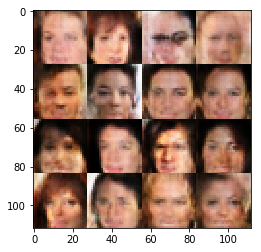

Epoch 1/1... Discriminator Loss: 1.4308... Generator Loss: 0.8034
Epoch 1/1... Discriminator Loss: 1.4565... Generator Loss: 0.7057
Epoch 1/1... Discriminator Loss: 1.4283... Generator Loss: 0.7108
Epoch 1/1... Discriminator Loss: 1.4375... Generator Loss: 0.6626
Epoch 1/1... Discriminator Loss: 1.4172... Generator Loss: 0.7326
Epoch 1/1... Discriminator Loss: 1.4200... Generator Loss: 0.6722
Epoch 1/1... Discriminator Loss: 1.4264... Generator Loss: 0.7444
Epoch 1/1... Discriminator Loss: 1.4233... Generator Loss: 0.7788
Epoch 1/1... Discriminator Loss: 1.4197... Generator Loss: 0.7702
Epoch 1/1... Discriminator Loss: 1.4166... Generator Loss: 0.7156


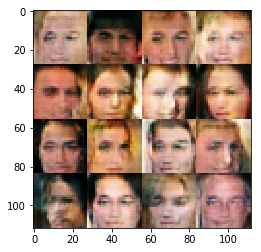

Epoch 1/1... Discriminator Loss: 1.4197... Generator Loss: 0.7191
Epoch 1/1... Discriminator Loss: 1.4413... Generator Loss: 0.6461
Epoch 1/1... Discriminator Loss: 1.4251... Generator Loss: 0.8329
Epoch 1/1... Discriminator Loss: 1.4157... Generator Loss: 0.7672
Epoch 1/1... Discriminator Loss: 1.4349... Generator Loss: 0.7749
Epoch 1/1... Discriminator Loss: 1.4476... Generator Loss: 0.7662
Epoch 1/1... Discriminator Loss: 1.4227... Generator Loss: 0.7492
Epoch 1/1... Discriminator Loss: 1.4349... Generator Loss: 0.8113
Epoch 1/1... Discriminator Loss: 1.4312... Generator Loss: 0.7441
Epoch 1/1... Discriminator Loss: 1.4250... Generator Loss: 0.8206


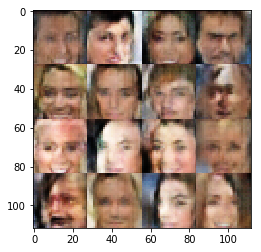

Epoch 1/1... Discriminator Loss: 1.4134... Generator Loss: 0.7266
Epoch 1/1... Discriminator Loss: 1.4234... Generator Loss: 0.7542
Epoch 1/1... Discriminator Loss: 1.4131... Generator Loss: 0.7839
Epoch 1/1... Discriminator Loss: 1.4182... Generator Loss: 0.7208
Epoch 1/1... Discriminator Loss: 1.4231... Generator Loss: 0.7887
Epoch 1/1... Discriminator Loss: 1.4540... Generator Loss: 0.6920
Epoch 1/1... Discriminator Loss: 1.4480... Generator Loss: 0.6328
Epoch 1/1... Discriminator Loss: 1.4220... Generator Loss: 0.7103
Epoch 1/1... Discriminator Loss: 1.4459... Generator Loss: 0.6290
Epoch 1/1... Discriminator Loss: 1.4489... Generator Loss: 0.6674


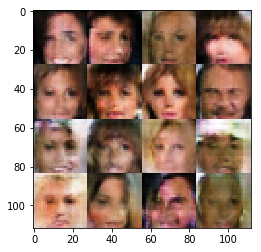

Epoch 1/1... Discriminator Loss: 1.4416... Generator Loss: 0.6705
Epoch 1/1... Discriminator Loss: 1.4192... Generator Loss: 0.6744
Epoch 1/1... Discriminator Loss: 1.4300... Generator Loss: 0.8289
Epoch 1/1... Discriminator Loss: 1.4244... Generator Loss: 0.7696
Epoch 1/1... Discriminator Loss: 1.4360... Generator Loss: 0.6888
Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.7543
Epoch 1/1... Discriminator Loss: 1.4407... Generator Loss: 0.7896
Epoch 1/1... Discriminator Loss: 1.4321... Generator Loss: 0.7208
Epoch 1/1... Discriminator Loss: 1.4228... Generator Loss: 0.6872
Epoch 1/1... Discriminator Loss: 1.4347... Generator Loss: 0.6604


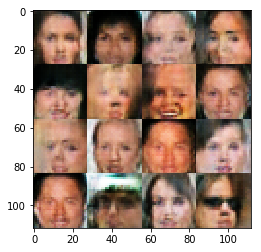

Epoch 1/1... Discriminator Loss: 1.4220... Generator Loss: 0.7358
Epoch 1/1... Discriminator Loss: 1.4523... Generator Loss: 0.7438
Epoch 1/1... Discriminator Loss: 1.4177... Generator Loss: 0.7569
Epoch 1/1... Discriminator Loss: 1.4343... Generator Loss: 0.7247
Epoch 1/1... Discriminator Loss: 1.4165... Generator Loss: 0.8163
Epoch 1/1... Discriminator Loss: 1.4305... Generator Loss: 0.7161
Epoch 1/1... Discriminator Loss: 1.4531... Generator Loss: 0.7355
Epoch 1/1... Discriminator Loss: 1.4355... Generator Loss: 0.6713
Epoch 1/1... Discriminator Loss: 1.4506... Generator Loss: 0.6431
Epoch 1/1... Discriminator Loss: 1.4281... Generator Loss: 0.6767


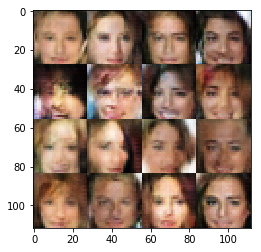

Epoch 1/1... Discriminator Loss: 1.4194... Generator Loss: 0.7144


KeyboardInterrupt: 

In [18]:
# I stopped when it generates realistic faces
# batch_size = 32
# z_dim = 200
# learning_rate = 0.001
# beta1 = 0.3

batch_size = 32
z_dim = 200
learning_rate = 0.001
beta1 = 0.3
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.